In [1]:

import numpy as np
import sys

from utils.file_utils import get_config
from dataset.occ_flow_utils import GridMap
from dataset.I24Dataset import I24Dataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
import flow_vis
import matplotlib.image as mpimg
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
config = get_config()

gridmap = GridMap(config)
dataset = I24Dataset(config)
grid_size_x = config.dataset.grid_size_x
grid_size_y = config.dataset.grid_size_y

In [8]:
def process_data_for_visualization(data_dic):
    prv_data_dic = data_dic['prv']
    cur_data_dic = data_dic['cur']
    nxt_data_dic = data_dic['nxt']
    prv_scene_occ_ogm, prv_scene_obs_ogm, prv_scene_flow_map = gridmap.get_map_flow(prv_data_dic)
    cur_scene_occ_ogm, cur_scene_obs_ogm, cur_scene_flow_map = gridmap.get_map_flow(cur_data_dic)
    nxt_scene_occ_ogm, nxt_scene_obs_ogm, nxt_scene_flow_map = gridmap.get_map_flow(nxt_data_dic)
    prv_scene_occ_ogm, prv_scene_obs_ogm, prv_scene_flow_map = prv_scene_occ_ogm.swapaxes(-2, -1), prv_scene_obs_ogm.swapaxes(-2, -1), prv_scene_flow_map.swapaxes(-2, -3)
    cur_scene_occ_ogm, cur_scene_obs_ogm, cur_scene_flow_map = cur_scene_occ_ogm.swapaxes(-2, -1), cur_scene_obs_ogm.swapaxes(-2, -1), cur_scene_flow_map.swapaxes(-2, -3)
    nxt_scene_occ_ogm, nxt_scene_obs_ogm, nxt_scene_flow_map = nxt_scene_occ_ogm.swapaxes(-2, -1), nxt_scene_obs_ogm.swapaxes(-2, -1), nxt_scene_flow_map.swapaxes(-2, -3)
    # change dtype to float32
    prv_scene_occ_ogm = prv_scene_occ_ogm.astype(np.float32)
    cur_scene_occ_ogm = cur_scene_occ_ogm.astype(np.float32)
    nxt_scene_occ_ogm = nxt_scene_occ_ogm.astype(np.float32)
    
    prv_scene_obs_ogm = prv_scene_obs_ogm.astype(np.float32)
    cur_scene_obs_ogm = cur_scene_obs_ogm.astype(np.float32)
    nxt_scene_obs_ogm = nxt_scene_obs_ogm.astype(np.float32)



    x = np.arange(0, cur_scene_flow_map.shape[2])  # X-axis points (256)
    y = np.arange(0, cur_scene_flow_map.shape[1])  # Y-axis points (128)
    X, Y = np.meshgrid(x, y)



    prv_scene_flow_map_rendered = np.sum(prv_scene_flow_map, axis=0)
    cur_scene_flow_map_rendered = np.sum(cur_scene_flow_map, axis=0)
    nxt_scene_flow_map_rendered = np.sum(nxt_scene_flow_map, axis=0)
    
    return X, Y, prv_scene_occ_ogm, cur_scene_occ_ogm, nxt_scene_occ_ogm, prv_scene_obs_ogm, cur_scene_obs_ogm, nxt_scene_obs_ogm, prv_scene_flow_map, cur_scene_flow_map, nxt_scene_flow_map, prv_scene_flow_map_rendered, cur_scene_flow_map_rendered, nxt_scene_flow_map_rendered


def set_white_to_transparent(image):
    """
    Converts white pixels in a normalized single-channel grayscale image (values between 0 and 1) 
    to transparent in RGBA format.

    Parameters:
    - image: NumPy array of shape (H, W) with pixel values in the range [0, 1].

    Returns:
    - rgba_image: NumPy array of shape (H, W, 4) with white pixels transparent.
    """
    # Ensure the input is a 2D grayscale image with normalized values
    if len(image.shape) != 2 or not np.all((image >= 0) & (image <= 1)):
        raise ValueError("Input must be a 2D single-channel grayscale image with values in the range [0, 1].")

    # Convert grayscale to RGB by stacking the grayscale values along 3 channels
    rgb_image = np.stack([image] * 3, axis=-1)

    # Convert to RGBA by adding an alpha channel initialized to 1 (fully opaque)
    rgba_image = np.dstack([rgb_image, np.ones_like(image)])

    # Identify white pixels (value == 1) and set their alpha to 0 (fully transparent)
    white_pixels = (image == 1)
    rgba_image[white_pixels, 3] = 0

    return rgba_image

def downsample(x, y, flow_map, down_sample_x=8, down_sample_y=3):
    """Downsample x, y, and flow_map with different rates for x and y axes."""
    x_down = x[::down_sample_y, ::down_sample_x]
    y_down = y[::down_sample_y, ::down_sample_x]
    flow_map_down = flow_map[:, ::down_sample_y, ::down_sample_x, :]
    return x_down, y_down, flow_map_down

def initialize_quiver(ax, flow_map, x, y):
    """Initialize the quiver plot with downsampled data."""
    x, y, flow_map = downsample(x, y, flow_map)
    mask = (flow_map[0, ..., 0] != 0) | (flow_map[0, ..., 1] != 0)
    X_masked, Y_masked = x[mask], y[mask]
    U_masked, V_masked = flow_map[0, ..., 0][mask], flow_map[0, ..., 1][mask]
    return ax.quiver(X_masked, Y_masked, U_masked, V_masked, 
                     angles='xy', scale_units='xy', scale=0.25, width=0.005, color='black', alpha=0.5)


def get_cmap(colors):
    
    return LinearSegmentedColormap.from_list('while-colors', colors, N=256)

def visualize(data_dic, name, vis_occ=True, vis_flow=True, vis_optical_flow=True):
    X, Y, prv_scene_occ_ogm, cur_scene_occ_ogm, nxt_scene_occ_ogm, prv_scene_obs_ogm, cur_scene_obs_ogm, nxt_scene_obs_ogm, prv_scene_flow_map, cur_scene_flow_map, nxt_scene_flow_map, prv_scene_flow_map_rendered, cur_scene_flow_map_rendered, nxt_scene_flow_map_rendered = process_data_for_visualization(data_dic)
    num_time_steps = cur_scene_occ_ogm.shape[0]
    # Define the custom colormap: white from 0 to 0.5, then gradually red from 0.5 to 1
    colors_occ = [
        (1, 1, 1),  # White for 0
        (1, 0.8, 0.8),  # Light red for mid-range
        (0, 1, 0)  # Red for 1
    ]
    cmap_occ = get_cmap(colors_occ)
    
    colors_obs = [
        (1, 1, 1),  # White for 0
        (1, 0.8, 0.8),  # Light red for mid-range
        (1, 0, 1)  # Red for 1
    ]
    cmap_obs = get_cmap(colors_obs)
    

    # Initialize the plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'wspace': 0, 'hspace': 0})
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    # # Create the meshgrid for the quiver plot
    # blue_square = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=15, label='Blue Square')
    # red_square = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=15, label='Red Square')
    # plt.legend(handles=[blue_square, red_square], loc='best')
    for ax in axes:
        ax.axis('off')

    axes[0].set_title('Previous Scene')
    axes[1].set_title('Current Scene')
    # axes[2].set_title('Next Scene')
    if vis_optical_flow:
        
        flow_rendered_prv = axes[0].imshow(flow_vis.flow_to_color(prv_scene_flow_map_rendered),interpolation='nearest', alpha=1)
        flow_rendered_cur = axes[1].imshow(flow_vis.flow_to_color(cur_scene_flow_map_rendered),interpolation='nearest', alpha=1)
        flow_rendered_nex = axes[2].imshow(flow_vis.flow_to_color(nxt_scene_flow_map_rendered),interpolation='nearest', alpha=1)
    # Initialize the occupancy map with the first frame's data
    if vis_occ:
        
        img_prv_occ_ogm = axes[0].imshow(prv_scene_occ_ogm[0], cmap=cmap_occ, interpolation='nearest', alpha=0.5)
        img_cur_occ_ogm = axes[1].imshow(cur_scene_occ_ogm[0], cmap=cmap_occ, interpolation='nearest', alpha=0.5)
        img_nxt_occ_ogm = axes[2].imshow(nxt_scene_occ_ogm[0], cmap=cmap_occ, interpolation='nearest', alpha=0.5)
        img_prv_obs_ogm = axes[0].imshow(prv_scene_obs_ogm[0], cmap=cmap_obs, interpolation='nearest', alpha=0.5)
        img_cur_obs_ogm = axes[1].imshow(cur_scene_obs_ogm[0], cmap=cmap_obs, interpolation='nearest', alpha=0.5)
        img_nxt_obs_ogm = axes[2].imshow(nxt_scene_obs_ogm[0], cmap=cmap_obs, interpolation='nearest', alpha=0.5)
    if vis_flow:
        quiver_prv = initialize_quiver(axes[0], prv_scene_flow_map, X, Y)
        quiver_cur = initialize_quiver(axes[1], cur_scene_flow_map, X, Y)
        quiver_nxt = initialize_quiver(axes[2], nxt_scene_flow_map, X, Y)

    road_lines_y = [12, 24, 36, 48, 60, -12, -24, -36, -48, -60]
    # Animation update function
    def update(frame):
        """Update both the quiver plot and the occupancy map for each frame."""
        # Update occupancy map
        for ax in axes:
            ax.clear()
            ax.axis('off')
        axes[0].set_title('Previous Scene')
        axes[1].set_title('Current Scene')
        axes[2].set_title('Next Scene')
        axes[0].scatter(X[::8, ::8], Y[::8, ::8], color='black', s=1, alpha=0.5)
        axes[1].scatter(X[::8, ::8], Y[::8, ::8], color='black', s=1, alpha=0.5)
        axes[2].scatter(X[::8, ::8], Y[::8, ::8], color='black', s=1, alpha=0.5)   

        if vis_optical_flow:
            flow_rendered_prv = axes[0].imshow(flow_vis.flow_to_color(prv_scene_flow_map_rendered),interpolation='nearest', alpha=1)
            flow_rendered_cur = axes[1].imshow(flow_vis.flow_to_color(cur_scene_flow_map_rendered),interpolation='nearest', alpha=1)
            flow_rendered_nex = axes[2].imshow(flow_vis.flow_to_color(nxt_scene_flow_map_rendered),interpolation='nearest', alpha=1)
            
        # Initialize the occupancy map with the first frame's data
        if vis_occ:
            
            img_prv_occ_ogm = axes[0].imshow(prv_scene_occ_ogm[frame], cmap=cmap_occ, interpolation='nearest', alpha=0.5)
            img_cur_occ_ogm = axes[1].imshow(cur_scene_occ_ogm[frame], cmap=cmap_occ, interpolation='nearest', alpha=0.5)
            img_nxt_occ_ogm = axes[2].imshow(nxt_scene_occ_ogm[frame], cmap=cmap_occ, interpolation='nearest', alpha=0.5)
            img_prv_obs_ogm = axes[0].imshow(prv_scene_obs_ogm[frame], cmap=cmap_obs, interpolation='nearest', alpha=0.5)
            img_cur_obs_ogm = axes[1].imshow(cur_scene_obs_ogm[frame], cmap=cmap_obs, interpolation='nearest', alpha=0.5)
            img_nxt_obs_ogm = axes[2].imshow(nxt_scene_obs_ogm[frame], cmap=cmap_obs, interpolation='nearest', alpha=0.5)
            
        def create_quiver(ax, flow_map, x, y):
            x, y, flow_map = downsample(x, y, flow_map)
            mask = (flow_map[frame, ..., 0] != 0) | (flow_map[frame, ..., 1] != 0)
            X_masked, Y_masked = x[mask], y[mask]
            U_masked, V_masked = flow_map[frame, ..., 0][mask], flow_map[frame,..., 1][mask]
            return ax.quiver(X_masked, Y_masked, U_masked, V_masked,
                             angles='xy', scale_units='xy', scale=0.25, width = 0.005, color='black', alpha=0.5)

        quiver_prv = create_quiver(axes[0], prv_scene_flow_map, X, Y)
        quiver_cur = create_quiver(axes[1], cur_scene_flow_map, X, Y)
        quiver_nxt = create_quiver(axes[2], nxt_scene_flow_map, X, Y)
        for ax in axes:
            for road_line_y in road_lines_y:
                y_coord = road_line_y * grid_size_y / 160 + grid_size_y / 2
                ax.hlines(
                    y=y_coord, xmin=0, xmax=grid_size_x,  # Start and end points on the x-axis
                    colors='black', linewidth=1
                )
        #
        return [quiver_prv, quiver_cur, quiver_nxt]

    # Create the animation

    ani = animation.FuncAnimation(fig, update, frames=num_time_steps, interval=50, blit=True)

    # Save the animation without padding or extra margins
    ani.save(name + '.mp4', writer='ffmpeg', fps=20, dpi=300)


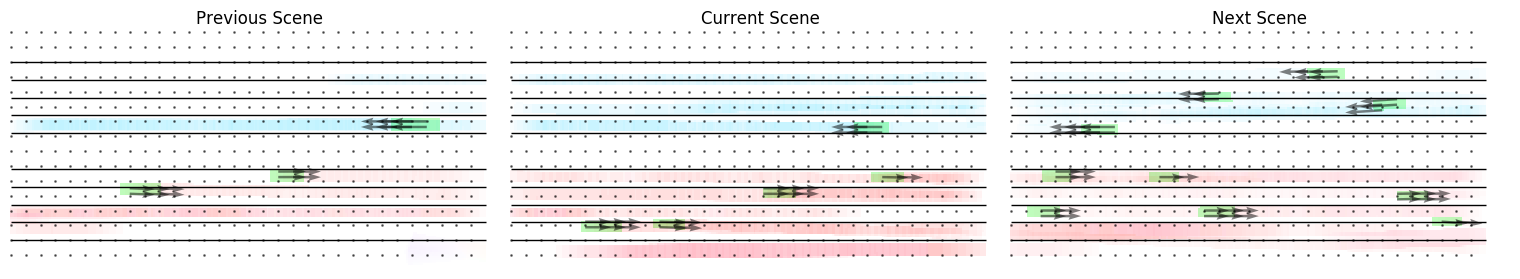

In [14]:
name = "scene_19915"
test_data = np.load(config.dataset.processed_data + '/' + name + '.npy', allow_pickle=True).item()

visualize(test_data, name, vis_occ=True, vis_flow=True, vis_optical_flow=True)

In [10]:
import numpy as np
from utils.file_utils import get_config
from dataset.occ_flow_utils import GridMap
config = get_config()
files = []
for i in range(20000):
    file_name = config.dataset.processed_data + '/scene_{}.npy'.format(i)
    test_data = np.load(file_name, allow_pickle=True).item()
    prv_data_dic = test_data['prv']
    cur_data_dic = test_data['cur']
    nxt_data_dic = test_data['nxt']
    # print(test_data['cur']['direction'])
    # if cur_data_dic['direction'] has 1 and -1
    if 1 in cur_data_dic['direction'] and -1 in cur_data_dic['direction']:
        num = np.sum(cur_data_dic['direction'] == 1)
        num_r = np.sum(cur_data_dic['direction'] == -1)
        if num > 5 and num_r > 5:
            files.append(file_name)
            print(f'{file_name} has {num} cars going forward and {num_r} cars going backward')


./processed_data//scene_398.npy has 6 cars going forward and 6 cars going backward
./processed_data//scene_482.npy has 6 cars going forward and 17 cars going backward
./processed_data//scene_488.npy has 6 cars going forward and 6 cars going backward
./processed_data//scene_664.npy has 6 cars going forward and 11 cars going backward
./processed_data//scene_665.npy has 8 cars going forward and 8 cars going backward
./processed_data//scene_1021.npy has 6 cars going forward and 6 cars going backward
./processed_data//scene_1199.npy has 6 cars going forward and 7 cars going backward
./processed_data//scene_1805.npy has 6 cars going forward and 7 cars going backward
./processed_data//scene_2089.npy has 7 cars going forward and 8 cars going backward
./processed_data//scene_3051.npy has 7 cars going forward and 6 cars going backward
./processed_data//scene_3142.npy has 6 cars going forward and 13 cars going backward
./processed_data//scene_3686.npy has 6 cars going forward and 9 cars going bac

In [93]:

file_name = config.dataset.processed_data + '/scene_{}.npy'.format(i)
test_data = np.load(file_name, allow_pickle=True).item()
prv_data_dic = test_data['prv']
cur_data_dic = test_data['cur']
nxt_data_dic = test_data['nxt']
# print(test_data['cur']['direction'])
# if cur_data_dic['direction'] has 1 and -1
if 1 in cur_data_dic['direction'] and -1 in cur_data_dic['direction']:
    num = np.sum(cur_data_dic['direction'] == 1)
    num_r = np.sum(cur_data_dic['direction'] == -1)
    print(f' 1 {num}  -1 {num_r} {file_name}')
    

 1 3  -1 16 /hdd/HetianGuo/I24/processed_data//scene_4999.npy


In [58]:
files

['/hdd/HetianGuo/I24/processed_data//scene_16.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_17.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_18.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_19.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_20.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_21.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_22.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_23.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_25.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_26.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_28.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_29.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_30.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_31.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_33.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_34.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_35.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_36.npy',
 '/hdd/HetianGuo/I24/processed_data//scene_37.npy',
 '/hdd/Hetia